In [1]:
%pylab inline

import seaborn as sns
import numpy as np

from sigvisa.models.ttime import tt_predict
from sigvisa.source.event import get_event, Event
from sigvisa import Sigvisa

import cPickle as pickle
from sigvisa.signals.io import load_event_station_chan, fetch_waveform

import scipy.misc

Populating the interactive namespace from numpy and matplotlib


/home/dmoore/python/sigvisa/treegp/gpy_linalg.py:39: UserWarning: warning: caught this exception:'module' object has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


In [2]:
s = Sigvisa()

sql_query = "select lebo.evid, l.time from leb_arrival l, leb_origin lebo, leb_assoc leba where lebo.orid=leba.orid and l.arid=leba.arid and l.sta=\"WRA\" and leba.phase=\"P\" and l.time between 1237680000 and 1237687200"
evids = s.sql(sql_query)

In [3]:
def load_array_waveforms(site, stime, etime, filter_str):
    elements = s.get_array_elements(site)
    waves = {}
    for element in elements:
        wave = fetch_waveform(element, "auto", stime, etime)
        waves[element] = wave.filter(filter_str)
    return waves

all_waves = load_array_waveforms("WRA", 1237681000, 1237681100,"freq_0.8_4.5;hz_10")

/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/scipy/signal/signaltools.py:3073: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


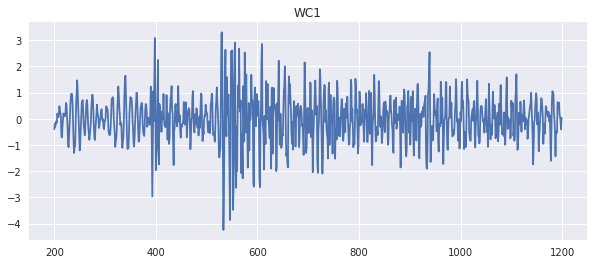

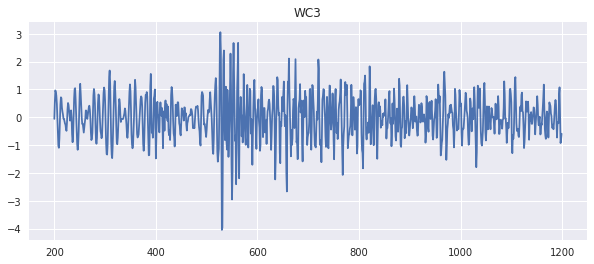

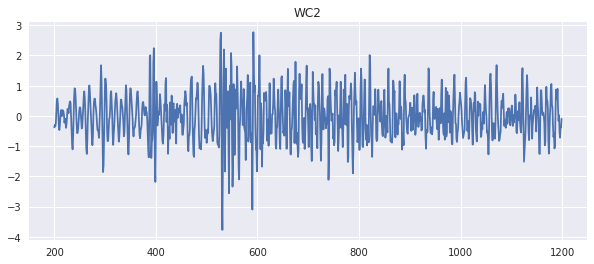

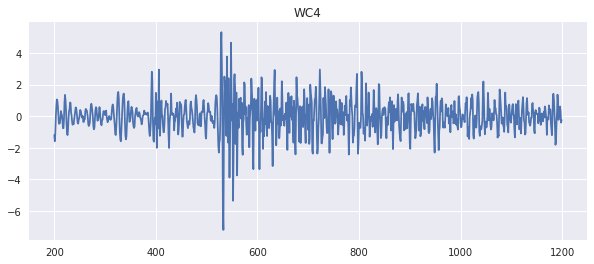

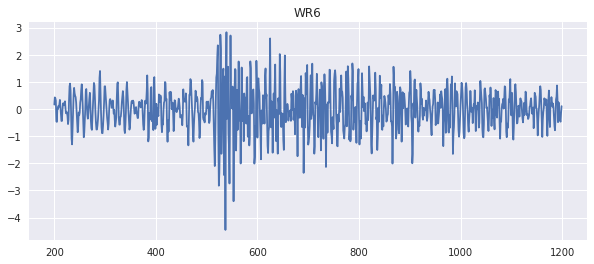

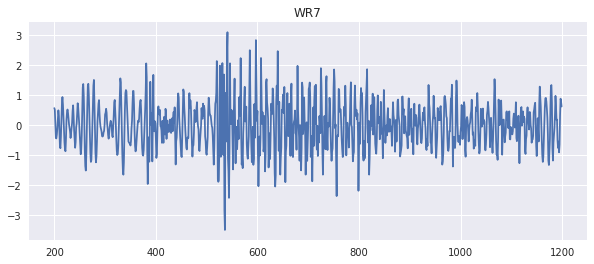

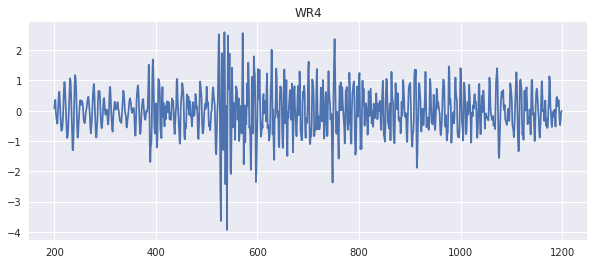

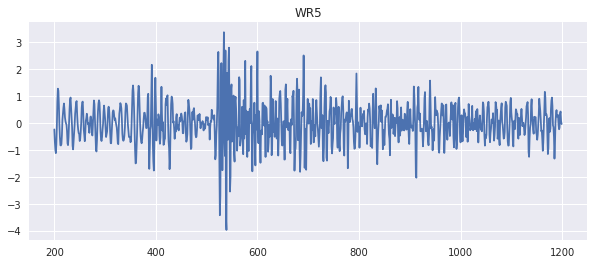

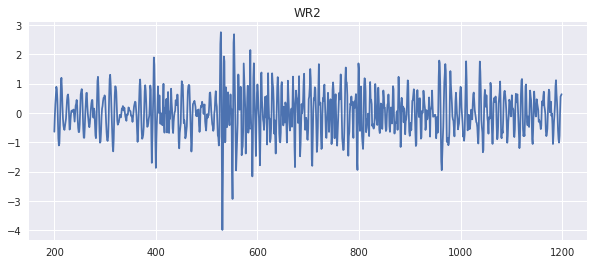

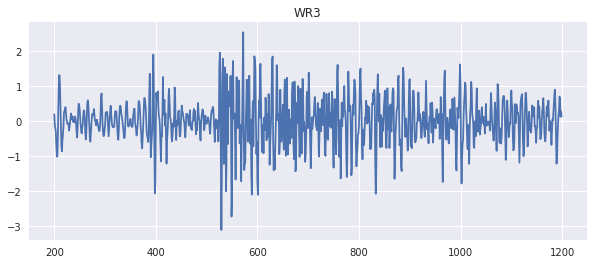

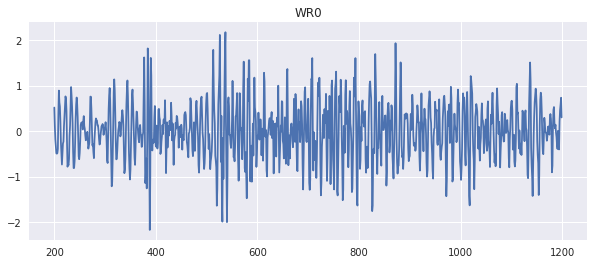

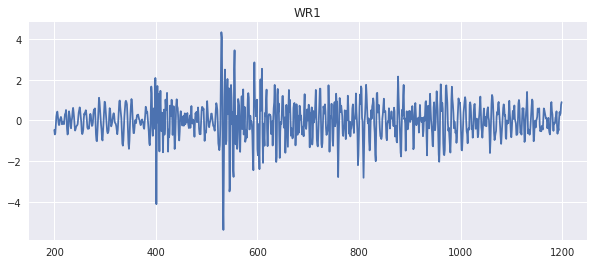

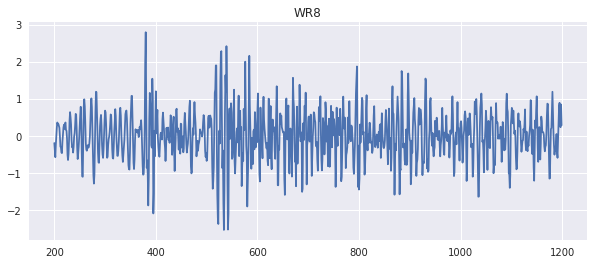

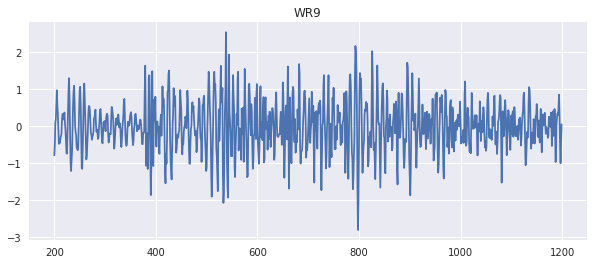

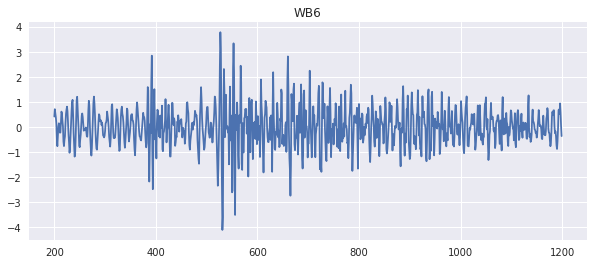

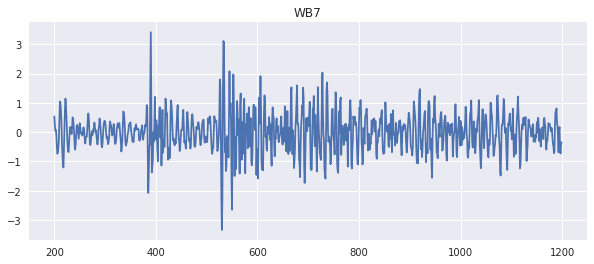

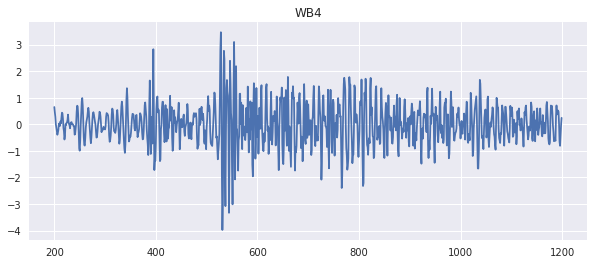

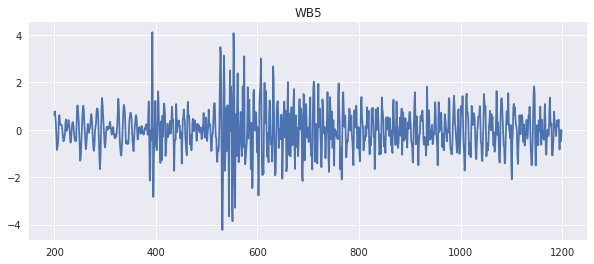

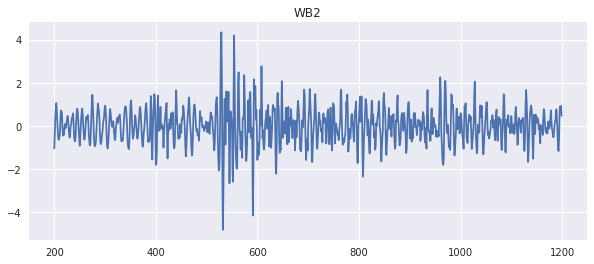

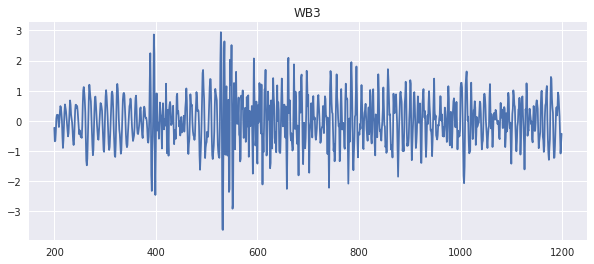

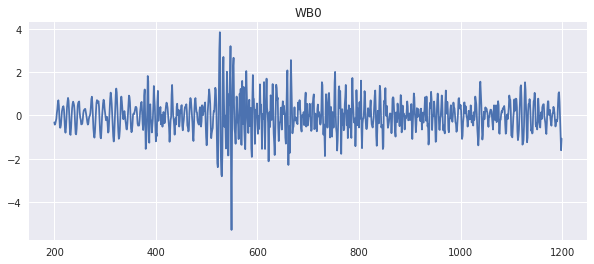

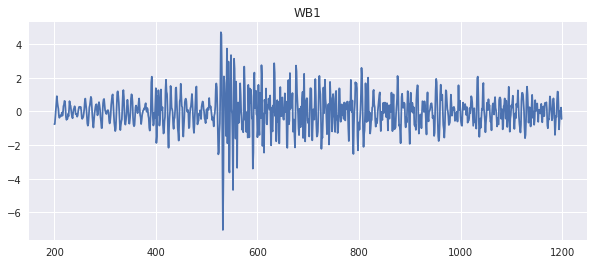

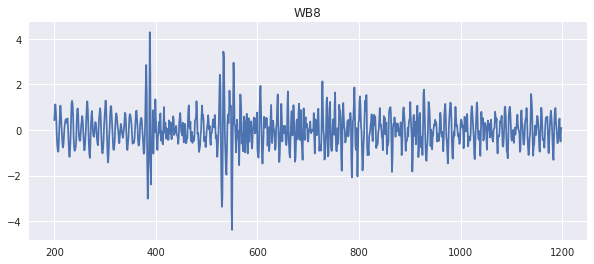

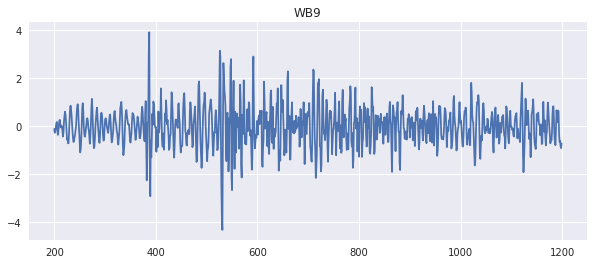

In [4]:
for sta, wave in all_waves.items():
    plt.figure(figsize=(10, 4))
    plt.plot(wave.data)
    plt.title(sta)

In [5]:
# take a chunk at the refsta (20s?)
# for each of some number of incoming angles (360?) calculate the corresponding atimes at all the other components. 
#   - will require some assumptions about event distance / the tt model? 
# then evaluate coherence of those times somehow
#   - total noise-model (iid or AR) likelihood of other stations after subtracting 
#      - the refsta window?
#      - the stacked window?
# somehow we want to approximate the likelihood of the full GP model. 
#   TODO think through this

In [6]:
from sigvisa.utils.array import index_to_time, time_to_index

    
def proxylp_sta(sta_data, template, min_idx, max_idx, iid_std=1.0):
    """
    Compute likelihood of observed data sta_data, 
    under the simple proxy model in 
    which the signal is composed of iid Gaussian noise with std iid_std, 
    plus the given template at some unknown alignment (start time) 
    between min_idx (inclusive) and max_idx (exclusive).
    
    For any given alignment idx, this is equivalent to the iid noise likelihood
    of the *difference* 
       sta_data - aligned(template, idx)
    in which we subtract the template at the given alignment. 
    
    Since we have only bounds on the alignment, we try all possibilities, and 
    sum the probabilities (logsumexp of log probabilities) to get the total 
    probability of an explanation within these bounds. 
    (in practice we hope the 'true' alignment will dominate, so we 
    could equally well take the max, but as long as we're computing all probabilities 
    we might as well use them)
    """   
        
    lps = []
    npts = len(template)

    # normalize the data and template so we can assume std=1 to simplify somewhat
    norm_data = sta_data / iid_std
    norm_tmpl = template / iid_std
    
    # compute base logp of the unmodified signal
    logZ = len(norm_data) * .5 * np.log(2*np.pi*iid_std**2)
    global_lp = -.5 * np.sum((norm_data)**2) - logZ
    
    # logp for each alignment is an adjustment to the base lp
    lps = []
    for idx in range(min_idx, max_idx):
        window = norm_data[idx:idx+npts]
        base = -.5 * np.sum(window**2)
        diff = -.5 * np.sum((window - norm_tmpl)**2)
        lps.append(global_lp -base + diff )
        
    signal_lp = scipy.misc.logsumexp(lps) - np.log(len(lps))
    best_idx = min_idx + np.argmax(lps)
    return signal_lp, best_idx

In [7]:
def back_construct_ev(sta, atime, azi, slo):
    # given a station, construct the event that generates a given P atime
    # and has a given azimuth and slowness.
    s = Sigvisa()
    elon, elat, edepth, etime = s.earthmodel.InvertDetection(sta, azi, slo, atime)
    if atime > 10 and etime < 10:
        # C code will return uninitialized mem on error, usually near zero so just test for that. 
        # this is obviously terrible of course.
        raise Exception("could not invert azi %.2f slo %.2f at refsta %s" % (azi, slo, refsta))
    
    ev = Event(lon=elon, lat=elat, mb=4.0, depth=edepth, time=etime)
    
    pred_atime = ev.time + tt_predict( ev, sta, "P", force=True)
    print "target atime %.2f actual %.2f" % (atime, pred_atime)
    
    return ev

In [46]:
def extract_window_data(wave, stime, len_s):
    sidx = time_to_index(stime, wave["stime"], wave["srate"])
    eidx = time_to_index(stime + len_s, wave["stime"], wave["srate"])
    return wave.data[sidx:eidx]

def azi_slowness_proxy_loglikelihood(site, sta_signals, 
                                     refsta_atime, 
                                     template_len_s = 15.0,
                                     window_pre_s = 10.0,
                                     window_post_s = 10.0,
                                     n_bins_azi=20, n_bins_slow=5, 
                                     iid_std=None):
    refsta= "WB2" #s.get_default_sta(site)
    refsta_atime = 1237681032.79
    
    # assume all windows start at the same time
    refsta_signal = sta_signals[refsta]

    if iid_std is None:
        iid_std = np.std(refsta_signal.data)

    # extract the template at the refsta
    template = extract_window_data(refsta_signal, refsta_atime, template_len_s)

    window_stime = refsta_atime - window_pre_s
    window_srate = refsta_signal["srate"]
    sta_windows = {sta: extract_window_data(signal, 
                                            window_stime, 
                                            window_pre_s + template_len_s + window_post_s)
                  for (sta, signal) in sta_signals.items()}
    
    azimuth_bins = np.linspace(0, 360, n_bins_azi+1)
    
    # slowness in secs/degree. these assume a P wave velocity,
    # but really the point is just to cover a range of incident angles.
    # the given bounds seem to be the valid ones where inversion doesn't 
    # choke. (iangle purely horizontal would be about 19, but 
    # P waves only defined for distance > 2deg...)
    slowness_bins = np.linspace(4.5, 19.1, n_bins_slow+1)

    lps = np.empty((n_bins_azi, n_bins_slow))
    
    aligned_idxs = []
    
    for i in range(n_bins_azi):
        min_azi, max_azi = azimuth_bins[i], azimuth_bins[i+1]
        
        aligned_idxs_azi = []
        for j in range(n_bins_slow):
            min_slow, max_slow = slowness_bins[j], slowness_bins[j+1]

            #if i != best_azi or j != best_slo:
            #    continue
            
            # generate four events in the corners of the azimuth/slowness bounds
            #  (note: in principle could store and reuse these for an array, just shifting the atime/origin time)
            ev11 = back_construct_ev(refsta, refsta_atime, min_azi, min_slow)
            ev12 = back_construct_ev(refsta, refsta_atime, min_azi, max_slow)
            ev21 = back_construct_ev(refsta, refsta_atime, max_azi, min_slow)
            ev22 = back_construct_ev(refsta, refsta_atime, max_azi, max_slow)

            total_lp = 0.0
            
            aligned_idxs_bysta = {}
            for sta in sta_windows.keys():

                if sta == refsta:
                    # no point in modeling refsta, could only cause confusion/aliasing bugs
                    continue
                
                # get a min and max atime for this signal at this station, 
                # given the azi/slowness bounds, by predicting the possibilities 
                # for events at the corners of the region. 
                # TODO: work out the geometry, does this really give valid bounds? 
                #        is it a problem that this doesn't necessarily partition the
                #        atime space? (i.e., adjacent azi/slowness regions might give
                #        overlapping atime bounds? I haven't thought through this at all)
                atime11 = ev11.time + tt_predict(ev11, sta, "P", force=True)
                atime12 = ev12.time + tt_predict(ev12, sta, "P", force=True)
                atime21 = ev21.time + tt_predict(ev21, sta, "P", force=True)
                atime22 = ev22.time + tt_predict(ev22, sta, "P", force=True)
                atimes = (atime11, atime12, atime21, atime22)
                min_atime = np.min(atimes)
                max_atime = np.max(atimes)
                
                min_idx = time_to_index(min_atime, stime=window_stime, srate=window_srate)
                max_idx = time_to_index(max_atime, stime=window_stime, srate=window_srate) + 1
                
                sta_lp, best_idx = proxylp_sta(sta_windows[sta], template, min_idx, max_idx, iid_std=iid_std)
                print "sta %s azi %.2f slo %.2f idx %d-%d lp %.2f" % (sta, min_azi, min_slow, min_idx, max_idx, sta_lp)
                
                aligned_idxs_bysta[sta] = best_idx
                
                total_lp += sta_lp
            aligned_idxs_azi.append(aligned_idxs_bysta)
            lps[i,j] = total_lp
        aligned_idxs.append(aligned_idxs_azi)

    return lps, azimuth_bins, slowness_bins, template, sta_windows, aligned_idxs

In [69]:
def visualize_alignment_all(sta_windows, template, alignment):
    nstas = len(sta_windows.keys())
    f = plt.figure(figsize=(15, 3*nstas))

    for i, sta in enumerate(sorted(sta_windows.keys())):
        ax = f.add_subplot(nstas, 1, i+1)


        s = sta_windows[sta]
        ax.plot(s, color="black")

        try:
            idx = alignment[sta]
        except:
            continue

        ax.plot(np.arange(idx, idx + len(template)), template, color="blue")
        ax.set_title(sta)
    
def visualize_alignment_stack(sta_windows, alignment, ref_alignment=100):
    nstas = len(sta_windows.keys())
    f = plt.figure(figsize=(15, 3))
    ax = f.add_subplot(111)
    
    for i, sta in enumerate(sorted(sta_windows.keys())):
        try:
            idx = alignment[sta]
        except:
            idx = ref_alignment
        
        begin_idx = ref_alignment - idx
        s = sta_windows[sta]
        t = np.arange(begin_idx, begin_idx + len(s))
        ax.plot(t, s, color="black", alpha=0.1)

In [48]:
lps, abins, sbins, template, sta_windows, aligned_idxs = \
    azi_slowness_proxy_loglikelihood("WRA", all_waves, 
                                     refsta_atime=1237681032.79, 
                                     template_len_s = 15.0,
                                     window_pre_s = 10.0,
                                     window_post_s = 10.0,
                                     n_bins_azi=60, n_bins_slow=30, 
                                     iid_std=None)

target atime 1237681032.79 actual 1237681032.79
target atime 1237681032.79 actual 1237681032.79
target atime 1237681032.79 actual 1237681032.79
target atime 1237681032.79 actual 1237681032.79
sta WC1 azi 0.00 slo 4.50 idx 99-100 lp -816.50
sta WC3 azi 0.00 slo 4.50 idx 100-101 lp -623.15
sta WC2 azi 0.00 slo 4.50 idx 99-100 lp -472.77
sta WC4 azi 0.00 slo 4.50 idx 100-101 lp -632.89
sta WR6 azi 0.00 slo 4.50 idx 100-101 lp -700.36
sta WR7 azi 0.00 slo 4.50 idx 99-101 lp -639.65
sta WR4 azi 0.00 slo 4.50 idx 100-101 lp -701.82
sta WR5 azi 0.00 slo 4.50 idx 100-101 lp -723.17
sta WR2 azi 0.00 slo 4.50 idx 100-101 lp -467.47
sta WR3 azi 0.00 slo 4.50 idx 100-101 lp -665.98
sta WR0 azi 0.00 slo 4.50 idx 99-101 lp -536.42
sta WR1 azi 0.00 slo 4.50 idx 99-101 lp -468.71
sta WR8 azi 0.00 slo 4.50 idx 99-101 lp -543.22
sta WR9 azi 0.00 slo 4.50 idx 99-101 lp -551.82
sta WB6 azi 0.00 slo 4.50 idx 95-97 lp -789.90
sta WB7 azi 0.00 slo 4.50 idx 94-96 lp -684.77
sta WB4 azi 0.00 slo 4.50 idx 98-99

484
16 4
-11496.6225716
-11496.6225716


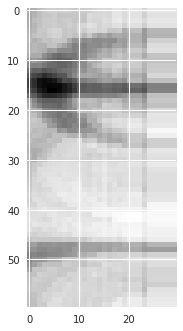

In [49]:
plt.imshow(lps)
print np.argmax(lps)
best_azi =  np.argmax(lps) / lps.shape[1]
best_slo = np.argmax(lps) - best_azi * lps.shape[1]
print best_azi, best_slo

print np.max(lps)
print lps[best_azi, best_slo]

alignment = aligned_idxs[best_azi][best_slo]

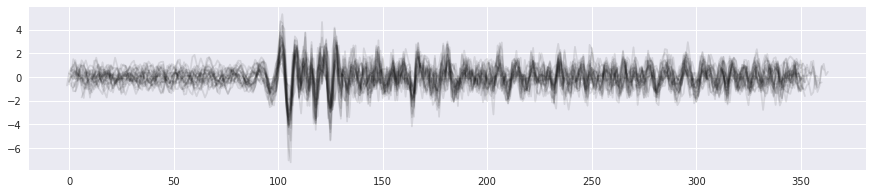

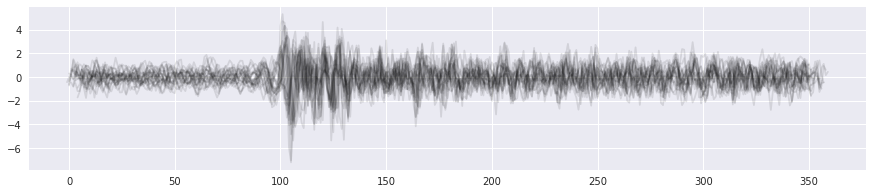

In [70]:
visualize_alignment_stack(sta_windows, aligned_idxs[best_azi][best_slo], ref_alignment=100)
visualize_alignment_stack(sta_windows, aligned_idxs[10][2], ref_alignment=100)

In [13]:
print evids

((5288041L, 1237680749.72), (5269697L, 1237681032.6), (5270714L, 1237681266.65), (5269733L, 1237682023.4), (5269769L, 1237683028.95), (5288032L, 1237683897.17), (5269822L, 1237684003.88), (5269819L, 1237684378.97), (5269817L, 1237684551.42), (5269863L, 1237685660.95), (5270272L, 1237686741.58), (5269915L, 1237686894.08))


In [51]:
true_ev = get_event(evid=5269697)

s = Sigvisa()
siteid = s.earthmodel.site_info("WRA", 0)[6]
true_az = s.earthmodel.ArrivalAzimuth(true_ev.lon, true_ev.lat, "WRA", true_ev.time)
true_slo = s.earthmodel.ArrivalSlowness(true_ev.lon, true_ev.lat, true_ev.depth, 0, "WRA", true_ev.time)
print true_az, true_slo

94.5745288568 7.5661


target atime 1237681032.79 actual 1237681032.79


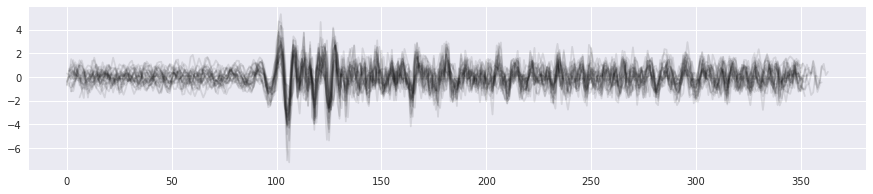

In [71]:
refsta="WB2"
refsta_atime = 1237681032.79

true_event2 = back_construct_ev(refsta, refsta_atime, true_az, true_slo)
true_aligned_idxs = {}
for sta in sta_windows.keys():

    if sta == refsta:
        # no point in modeling refsta, could only cause confusion/aliasing bugs
        continue

    atime_true = true_event2.time + tt_predict(true_event2, sta, "P", force=True)
    true_idx = time_to_index(atime_true, stime=window_stime, srate=10) 
    true_aligned_idxs[sta] = true_idx
    
visualize_alignment_stack(sta_windows, true_aligned_idxs, ref_alignment=100)


In [72]:

best_azi =  np.argmax(lps) / lps.shape[1]
best_slo = np.argmax(lps) - best_azi * lps.shape[1]

#best_azi -= 1
#best_slo += 2

print best_azi, best_slo


16 4


In [73]:
print abins[best_azi], abins[best_azi+1]
print sbins[best_slo], sbins[best_slo+1]

96.0 102.0
6.44666666667 6.93333333333


In [76]:
refsta="WB2"
refsta_atime = 1237681032.79
window_pre_s = 10.0
window_post_s = 10.0
window_stime = refsta_atime - window_pre_s
refsta_signal = all_waves[refsta]
template_len_s = 15.0


template = extract_window_data(refsta_signal, refsta_atime, template_len_s)

sta_windows = {sta: extract_window_data(signal, 
                                        window_stime, 
                                        window_pre_s + template_len_s + window_post_s)
                  for (sta, signal) in all_waves.items()}

min_azi, max_azi = abins[best_azi], abins[best_azi+1]
min_slow, max_slow = sbins[best_slo], sbins[best_slo+1]
ev11 = back_construct_ev(refsta, refsta_atime, min_azi, min_slow)
ev12 = back_construct_ev(refsta, refsta_atime, min_azi, max_slow)
ev21 = back_construct_ev(refsta, refsta_atime, max_azi, min_slow)
ev22 = back_construct_ev(refsta, refsta_atime, max_azi, max_slow)

true_event2 = back_construct_ev(refsta, refsta_atime, true_az, true_slo)



total_bin = 0.0
total_true = 0.0
aligned_idxs_bysta = {}
for sta in sta_windows.keys():

    if sta == refsta:
        # no point in modeling refsta, could only cause confusion/aliasing bugs
        continue

    # get a min and max atime for this signal at this station, 
    # given the azi/slowness bounds, by predicting the possibilities 
    # for events at the corners of the region. 
    # TODO: work out the geometry, does this really give valid bounds? 
    #        is it a problem that this doesn't necessarily partition the
    #        atime space? (i.e., adjacent azi/slowness regions might give
    #        overlapping atime bounds? I haven't thought through this at all)
    atime11 = ev11.time + tt_predict(ev11, sta, "P", force=True)
    atime12 = ev12.time + tt_predict(ev12, sta, "P", force=True)
    atime21 = ev21.time + tt_predict(ev21, sta, "P", force=True)
    atime22 = ev22.time + tt_predict(ev22, sta, "P", force=True)
    atime_true = true_event2.time + tt_predict(true_event2, sta, "P", force=True)

    atimes = (atime11, atime12, atime21, atime22)
    min_atime = np.min(atimes)
    max_atime = np.max(atimes)

    min_idx = time_to_index(min_atime, stime=window_stime, srate=10)
    max_idx = time_to_index(max_atime, stime=window_stime, srate=10) + 1
    
    true_idx = time_to_index(atime_true, stime=window_stime, srate=10) 
    
    sta_lp, best_idx = proxylp_sta(sta_windows[sta], template, min_idx, max_idx)
    true_lp, _ = proxylp_sta(sta_windows[sta], template, true_idx, true_idx+1)

    
    print "sta %s min %.2f max %.2f true %.2f" % (sta, min_atime, max_atime, atime_true)
    print "sta %s min %d max %d best %d true %d lps (%.1f %.1f)" % (sta, min_idx, max_idx, best_idx, true_idx, sta_lp, true_lp)
    if true_idx < min_idx or true_idx >= max_idx:
        print "OUT OF BOUNDS"
    print
        
    total_bin += sta_lp
    total_true += true_lp
    
print total_bin, total_true

target atime 1237681032.79 actual 1237681032.79
target atime 1237681032.79 actual 1237681032.79
target atime 1237681032.79 actual 1237681032.79
target atime 1237681032.79 actual 1237681032.79
target atime 1237681032.79 actual 1237681032.79
sta WC1 min 1237681032.88 max 1237681032.89 true 1237681032.89
sta WC1 min 100 max 102 best 101 true 100 lps (-475.0 -570.1)

sta WC3 min 1237681032.63 max 1237681032.65 true 1237681032.63
sta WC3 min 98 max 99 best 98 true 98 lps (-485.8 -485.8)

sta WC2 min 1237681032.71 max 1237681032.73 true 1237681032.70
sta WC2 min 99 max 100 best 99 true 99 lps (-470.9 -470.9)

sta WC4 min 1237681032.83 max 1237681032.85 true 1237681032.86
sta WC4 min 100 max 101 best 100 true 100 lps (-582.1 -582.1)

sta WR6 min 1237681032.11 max 1237681032.16 true 1237681032.05
sta WR6 min 93 max 94 best 93 true 92 lps (-521.1 -548.7)
OUT OF BOUNDS

sta WR7 min 1237681031.96 max 1237681032.02 true 1237681031.89
sta WR7 min 91 max 93 best 91 true 90 lps (-532.9 -564.7)
OUT OF

STATUS:
- we can load signals and compute an azi/slowness likelihood. this works, gives a plausible plot, AND puts mass on the true event (for this case at least).
- but with large bins (nazi=20, nslow=5) the modal bin actually doesn't contain the true ev. why not?
- also we should be able to get much finer-grained accuracy. can I run with hundreds of azi/slow bins?

We should be able to do the alignment computation *once* for each component. Then reuse this info as we move across bins. 

TODO:
 - first rearchitect to reuse alignment computations, for speed and clarity
 - then look at why we don't get the true ev/slowness within the modal bin. I conjecture that this has to do with my range computations, and I should be smarter about range (I'm adding +1, is this justified? etc)
     - a sanity check here would be to take the alignments from the true ev location. are these the best? if not, why not? maybe I need to explicitly model ttime uncertianty between array elements?
 - once I'm getting a beamformed estimate at least as accurate as station processing, move on to the Hough proposal. this will mean: either speed things up *or* do preprocessing and store the preprocessed signal. And then figure out a forward model by which to incorporate this infor into Hough bins. (should be: precompute azi/slowness for each phase at each bin. then just add azi/slowness to the hough score. but with a lot of smoothing/compression to account for weirdness in the computation, phase uncertainty, etc). 


# Evaluating multiple evs

TODO loop over all relevant evs at this station, compare beamformed estimates to the real location

/home/dmoore/python/sigvisa/treegp/gpy_linalg.py:39: UserWarning: warning: caught this exception:'module' object has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


1237680744.44 1237680799.44
1237681027.79 1237681082.79
1237681263.32 1237681318.32
1237682018.87 1237682073.87
1237683024.11 1237683079.11
1237683893.82 1237683948.82
1237683998.98 1237684053.98
1237684374.83 1237684429.83
1237684547.03 1237684602.03
1237685656.28 1237685711.28
1237686737.01 1237686792.01
1237686888.75 1237686943.75


/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


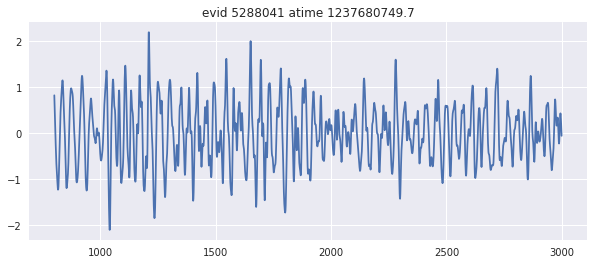

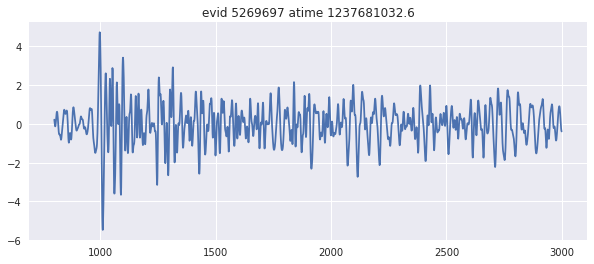

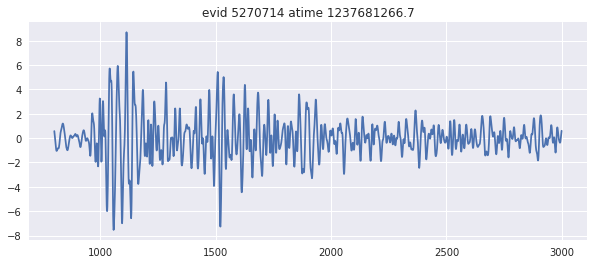

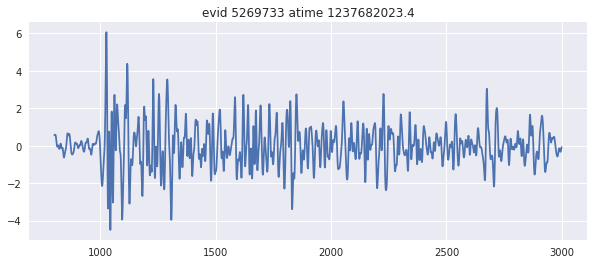

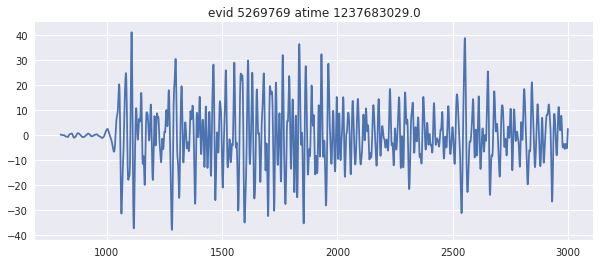

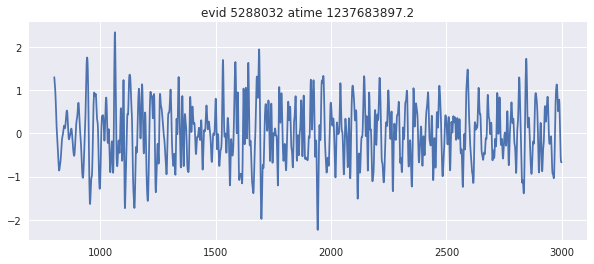

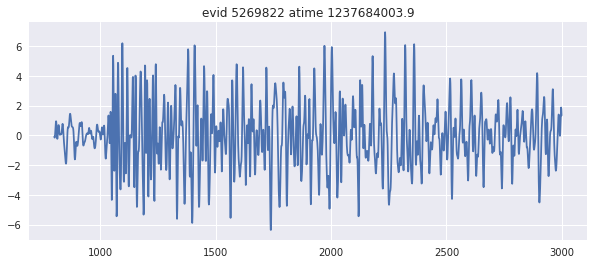

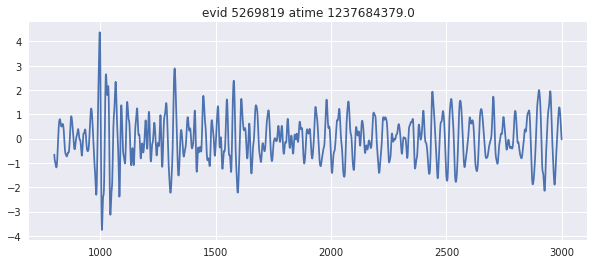

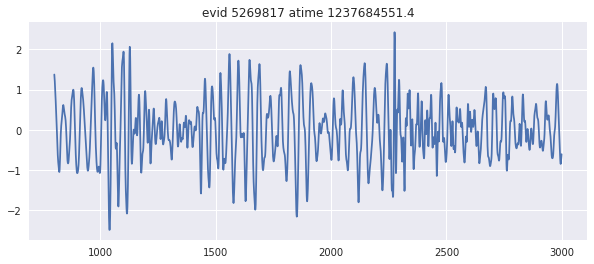

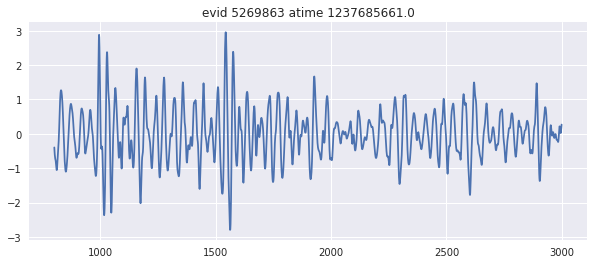

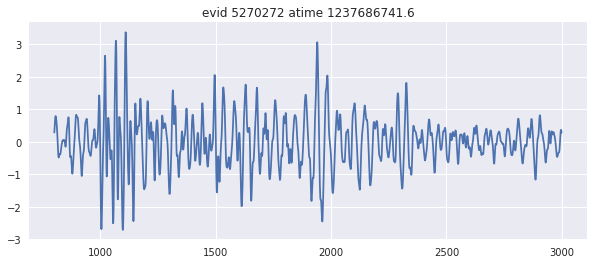

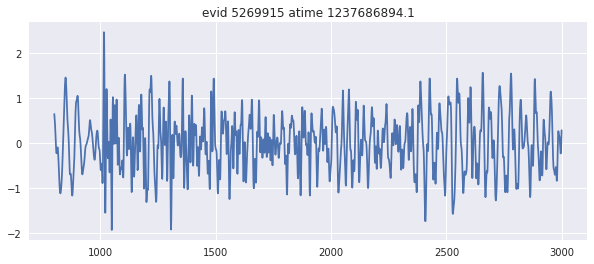

In [10]:
for evid, atime in evids:
    w1 = load_event_station_chan(evid, "WR1", "BHZ", pre_s=5, phases=["P",], post_s=50)
    wf1 = w1.filter("freq_0.8_4.5")
    plt.figure(figsize=(10, 4))
    plt.plot(wf1.data)
    plt.title("evid %d atime %.1f" % (evid, atime))